# Goal of this HW  
預測明日的Close Price與今日相比是上升或是下降

# Import Libraries and read data  

## Dataset  
S&P 500:https://www.sharecast.com/index/SP_500/prices/download  
Training set:  
 02-Jan-2009 to 29-Dec-2017  
Test set:  
 02-Jan-2018 to 31-Dec-2018

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc
from mplfinance.original_flavor import plot_day_summary_ohlc
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn import preprocessing, linear_model

from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor



train = pd.read_csv('source/Train.csv')
test = pd.read_csv('source/Test.csv')

# 區分資料以便合併
train['dataclass'] = 0
test['dataclass'] = 1

full = pd.concat([train, test])

# Data preprocession

定義問題，預測明日close price漲或跌，為二元分類問題。

In [2]:
# 與前一天close price比較 漲:1 跌:0
full['day_movement'] = np.where(full['Close Price'].shift(-1) > full['Close Price'], 1, 0)

OHLC candle stick chart繪製，並在底部加上volume bar chart。

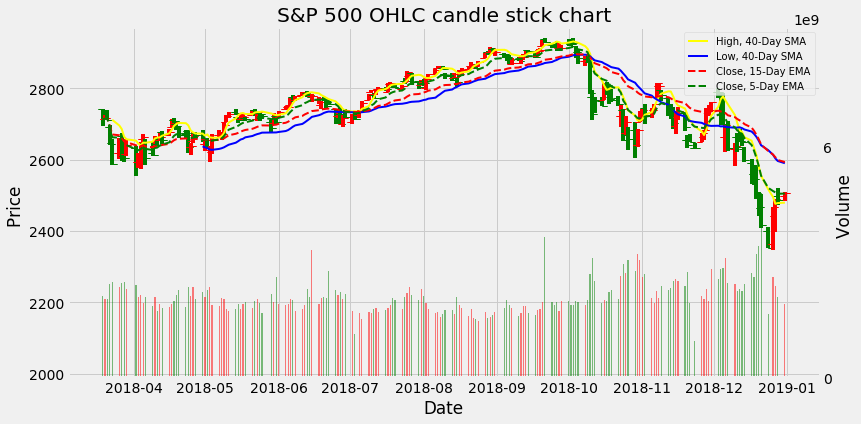

In [3]:
# 當天漲跌，ohlc chart用
full['movement'] = full['Close Price'] - full['Open Price']
full.loc[ full['movement'] <= 0, 'movement'] = 0
full.loc[ full['movement'] > 0, 'movement'] = 1

# 轉換日期時間，繪製chart用
full.index = pd.to_datetime(full['Date'])


# 轉換成list of lists資料，ohlc chart用
dvalues = full[['Open Price', 'High Price', 'Low Price', 'Close Price', 'Volume']].values.tolist()

# 將時間日期轉換成Matplotlib date format
pdates = mdates.date2num(full.index)

# list of lists型態ohlc資料，每條list型態為[date, open, high, low, close]
ohlc = [ [pdates[i]] + dvalues[i] for i in range(len(pdates)) ]


# 繪製ohlc candle stick chart
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (12,6))

# 取其中200筆資料繪製
plot_day_summary_ohlc(ax, ohlc[-200:], ticksize = 5, colorup = 'red', colordown = 'green')

ax.set_xlabel('Date')
ax.set_ylabel('Price ')
ax.set_title('S&P 500 OHLC candle stick chart')

# dates資料轉換成字串顯示
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# shift y-limits of the candlestick留空間給volume bar chart
pad = 0.5
yl = ax.get_ylim()
ax.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])

ax.grid(True)


# volume bar chart
ax2 = ax.twinx()

bar_train = full[-200:]
# 收盤價與開盤價比為負
neg = bar_train.loc[bar_train['movement'] == 0, 'Date']
negv = bar_train.loc[bar_train['movement'] == 0, 'Volume']
# 收盤價與開盤價比為正
pos = bar_train.loc[bar_train['movement'] == 1, 'Date']
posv = bar_train.loc[bar_train['movement'] == 1, 'Volume']
neg = pd.to_datetime(neg)
pos = pd.to_datetime(pos)
ax2.bar(neg, negv, color='green', width=0.5, align='center' , alpha=0.5)
ax2.bar(pos, posv, color='red', width=0.5, align='center' , alpha=0.5)


ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Volume ')

# y坐標軸值限制
ax2.set_ylim(0, max(train['Volume']))
# y坐標軸刻度
yticks = ax2.get_yticks()
ax2.set_yticks(yticks[::3])

ax2.grid(False)

# 計算SMA、EMA
hsma40 = bar_train['High Price'].rolling(5).mean()
lsma40 = bar_train['Low Price'].rolling(30).mean()
ema5 = bar_train['Close Price'].ewm(5).mean()
ema15 = bar_train['Close Price'].ewm(15).mean()

ax.plot(hsma40, color = 'yellow', linewidth = 2, label='High, 40-Day SMA')
ax.plot(lsma40, color = 'blue', linewidth = 2, label='Low, 40-Day SMA')
ax.plot(ema15, color = 'red', linestyle='--', linewidth = 2, label='Close, 15-Day EMA')
ax.plot(ema5, color = 'green', linestyle='--', linewidth = 2, label='Close, 5-Day EMA')
ax.legend(loc='upper right',  prop={'size': 10})


## Feature generation

In [4]:
# feature generation
# 5 day simple moving average
full['avg_price_5'] = full['Close Price'].rolling(5).mean()
# 5 day simple moving average movement
full['avg_movement'] = np.where(full['avg_price_5'].shift(-5) > full['avg_price_5'], 1, 0)
# 30 day simple moving average
full['avg_price_30'] = full['Close Price'].rolling(30).mean()
# 30 day simple moving average movement
full['30avg_movement'] = np.where(full['avg_price_30'].shift(-30) > full['avg_price_30'], 1, 0)


# 5 day Exponential Moving Average 
full['ema5'] = full['Close Price'].ewm(5).mean()
# ema與sma相較，對近期價格影響較大，所以只和前一天比較
# 5 day Exponential Moving Average movement
full['ema5_movement'] = np.where(full['ema5'].shift(-1) > full['ema5'], 1, 0)
# 30 day Exponential Moving Average 
full['ema30'] = full['Close Price'].ewm(30).mean()
# 30 day Exponential Moving Average  movement
full['ema30_movement'] = np.where(full['ema30'].shift(-1) > full['ema30'], 1, 0)

#volume與前一天比較 
full['volume_movement'] = np.where(full['Volume'].shift(-1) > full['Volume'], 1, 0)

# 只留下movement值，降低複雜度
full = full.drop(['avg_price_30', 'avg_price_5', 'movement', 'ema5', 'ema30', 'Volume'], axis = 1)


觀察各項feature與預測值的相關程度。

volume_movement   -0.103876
Close Price       -0.027920
High Price        -0.027313
Low Price         -0.027303
Open Price        -0.026884
dataclass         -0.015995
30avg_movement     0.111789
ema30_movement     0.148360
ema5_movement      0.348013
avg_movement       0.349086
day_movement       1.000000
Name: day_movement, dtype: float64


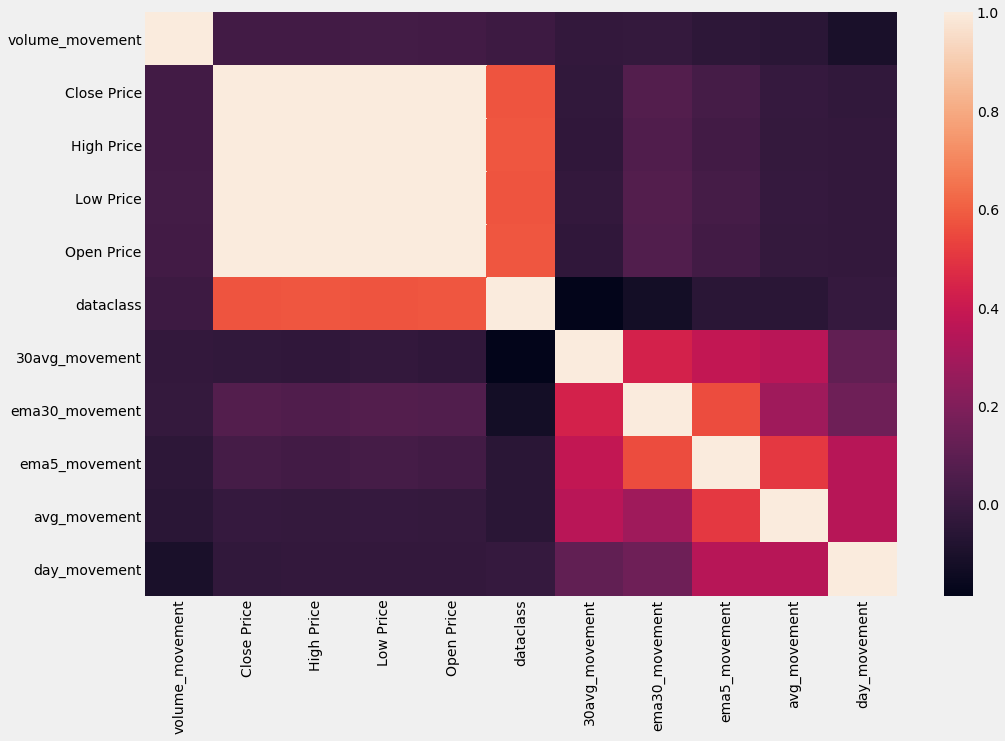

In [5]:
# 與目標值'day_movement'相關程度
sorted_corrs = full.corr()['day_movement'].sort_values()

print(sorted_corrs)
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(full[sorted_corrs.index].corr())

分開train、test。

In [6]:
# 分開train、test資料
X_train = full[full['dataclass'] == 0]
X_test = full[full['dataclass'] == 1]

# 捨棄Nan值
X_train = X_train.dropna()
X_train = X_train.reset_index(drop=True)
# X_test = X_test.dropna()
# 避免與訓練集混淆
X_test_clean = X_test

# 根據correlation值捨棄無關資料
x_train = X_train.drop(['Date', 'dataclass', 'Open Price', 'Close Price', 'High Price', 'Low Price'], axis = 1)

捨棄較無相關資料後，重新繪製各項feature與預測值的相關程度。

volume_movement   -0.097512
30avg_movement     0.105495
ema30_movement     0.148934
avg_movement       0.341609
ema5_movement      0.351494
day_movement       1.000000
Name: day_movement, dtype: float64


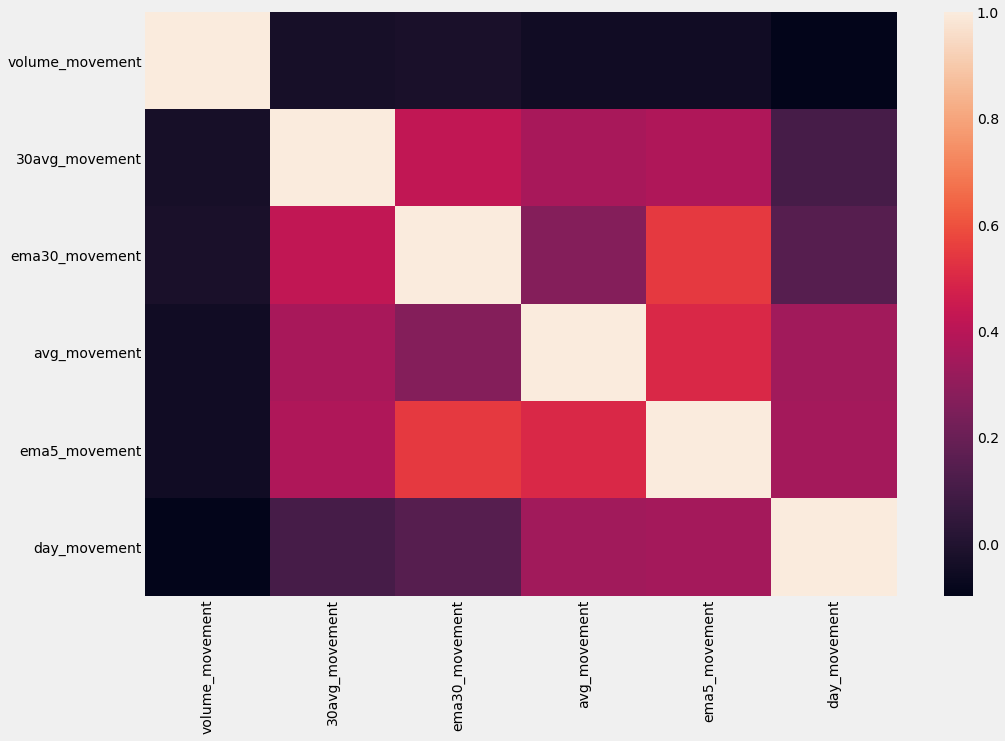

In [7]:
# 與目標值'day_movement'相關程度
sorted_corrs = x_train.corr()['day_movement'].sort_values()

print(sorted_corrs)
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(x_train[sorted_corrs.index].corr())

# 預測  
  
訓練資料處理。

In [8]:
# 切取訓練集、驗證集
X_train, X_test, y_train, y_test = train_test_split(x_train.drop('day_movement', axis = 1),
                                                    x_train['day_movement'], test_size = 0.2, 
                                                    random_state = 2)
# 亂數種子
random_seed = 4

# Logistic Regression

### hyperparameter tuning  

以RandomizedSearchCV tuning最佳超參數。

In [9]:
logistic_regr = linear_model.LogisticRegression()
logistic_regr_grid = {'C': [0.1, 0.3, 0.5, 0.9, 1],
                    'class_weight': ['balanced', None],
                    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                    'max_iter': [50, 100, 200, 500, 1000],
                    'random_state' : [random_seed]}  # 控制random seed

grid = RandomizedSearchCV(logistic_regr,logistic_regr_grid,cv = 3,scoring = 'neg_log_loss',n_jobs = -1, random_state = random_seed)
# 尋找參數
grid.fit(X_train, y_train)
# 返回最佳解
logistic_regr = grid.best_estimator_
print(logistic_regr)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=4, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)


以課程學長提供的5 fold cross validation驗證。

In [10]:
kf = KFold(n_splits=5,                                # 設定 K 值
           random_state=1012,
           shuffle=True)
kf.get_n_splits(X_train)                              # 給予資料範圍

train_acc_list = []                                   # 儲存每次訓練模型的準確度
valid_acc_list = []                                   # 儲存每次驗證模型的準確度

for train_index, valid_index in kf.split(X_train):    # 每個迴圈都會產生不同部份的資料
    train_x_split = X_train.iloc[train_index]         # 產生訓練資料
    train_y_split = y_train.iloc[train_index]         # 產生訓練資料標籤
    valid_x_split = X_train.iloc[valid_index]         # 產生驗證資料
    valid_y_split = y_train.iloc[valid_index]         # 產生驗證資料標籤
    
    # 設置最佳參數
    logistic_regr =  linear_model.LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                       intercept_scaling=1, l1_ratio=None, max_iter=500,
                       multi_class='auto', n_jobs=None, penalty='l2',
                       random_state=4, solver='newton-cg', tol=0.0001, verbose=0,
                       warm_start=False)
    logistic_regr.fit(train_x_split, train_y_split)

    train_pred_y = logistic_regr.predict(train_x_split)       # 確認模型是否訓練成功
    train_acc = accuracy_score(train_y_split,         # 計算訓練資料準確度
                               train_pred_y)
    valid_pred_y = logistic_regr.predict(valid_x_split)       # 驗證模型是否訓練成功
    valid_acc = accuracy_score(valid_y_split,         # 計算驗證資料準確度
                               valid_pred_y)
    
    train_acc_list.append(train_acc)
    valid_acc_list.append(valid_acc)

print((
        'average train accuracy: {}\n' +
        '    min train accuracy: {}\n' +
        '    max train accuracy: {}\n' +
        'average valid accuracy: {}\n' +
        '    min valid accuracy: {}\n' +
        '    max valid accuracy: {}').format(
        np.mean(train_acc_list),                          # 輸出平均訓練準確度
        np.min(train_acc_list),                           # 輸出最低訓練準確度
        np.max(train_acc_list),                           # 輸出最高訓練準確度
        np.mean(valid_acc_list),                          # 輸出平均驗證準確度
        np.min(valid_acc_list),                           # 輸出最低驗證準確度
        np.max(valid_acc_list)                            # 輸出最高驗證準確度
    ))


average train accuracy: 0.703478013032421
    min train accuracy: 0.6894409937888198
    max train accuracy: 0.7135955831608005
average valid accuracy: 0.6979498653029541
    min valid accuracy: 0.6657458563535912
    max valid accuracy: 0.7513812154696132


根據test集驗證準確率。

In [11]:
test_pred_y = logistic_regr.predict(X_test_clean.drop(['Date','day_movement', 'dataclass', 'Open Price', 'Close Price', 'High Price', 'Low Price'], axis = 1))

count = 0
for index in range(len(test_pred_y)):
    if ((test_pred_y[index] - X_test_clean['day_movement'][index]) == 0):
        count += 1

print('Accuracy: ', count / len(X_test_clean))

Accuracy:  0.6904761904761905


# Neural Network

### hyperparameter tuning  

以RandomizedSearchCV tuning最佳超參數。

In [12]:
mlp = MLPClassifier()
mlp_grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
            'alpha': [0.0001, 0.05],
            'activation' : ['logistic'], # 用和Logistic Regression一樣的activation function
            'learning_rate': ['constant','adaptive'],
            'max_iter': [200, 500, 700],
            'random_state' : [random_seed]} # 控制random seed

grid = RandomizedSearchCV(mlp,mlp_grid,cv = 3,scoring = 'neg_log_loss',n_jobs = -1, random_state = random_seed)
# 尋找參數
grid.fit(X_train, y_train)
# 返回最佳解
mlp = grid.best_estimator_
print(mlp)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 50, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=700,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=4, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


In [13]:
kf = KFold(n_splits=5,                                # 設定 K 值
           random_state=1012,
           shuffle=True)
kf.get_n_splits(X_train)                              # 給予資料範圍

train_acc_list = []                                   # 儲存每次訓練模型的準確度
valid_acc_list = []                                   # 儲存每次驗證模型的準確度

for train_index, valid_index in kf.split(X_train):    # 每個迴圈都會產生不同部份的資料
    train_x_split = X_train.iloc[train_index]         # 產生訓練資料
    train_y_split = y_train.iloc[train_index]         # 產生訓練資料標籤
    valid_x_split = X_train.iloc[valid_index]         # 產生驗證資料
    valid_y_split = y_train.iloc[valid_index]         # 產生驗證資料標籤
    
    # 設置最佳參數
    mlp = MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(50, 50, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=700,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=4, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
    mlp.fit(train_x_split,train_y_split)

    
    train_pred_y = mlp.predict(train_x_split)       # 確認模型是否訓練成功
    train_acc = accuracy_score(train_y_split,         # 計算訓練資料準確度
                               train_pred_y)
    valid_pred_y = mlp.predict(valid_x_split)       # 驗證模型是否訓練成功
    valid_acc = accuracy_score(valid_y_split,         # 計算驗證資料準確度
                               valid_pred_y)
    
    train_acc_list.append(train_acc)
    valid_acc_list.append(valid_acc)

print((
        'average train accuracy: {}\n' +
        '    min train accuracy: {}\n' +
        '    max train accuracy: {}\n' +
        'average valid accuracy: {}\n' +
        '    min valid accuracy: {}\n' +
        '    max valid accuracy: {}').format(
        np.mean(train_acc_list),                          # 輸出平均訓練準確度
        np.min(train_acc_list),                           # 輸出最低訓練準確度
        np.max(train_acc_list),                           # 輸出最高訓練準確度
        np.mean(valid_acc_list),                          # 輸出平均驗證準確度
        np.min(valid_acc_list),                           # 輸出最低驗證準確度
        np.max(valid_acc_list)                            # 輸出最高驗證準確度
    ))

average train accuracy: 0.7043060750603388
    min train accuracy: 0.6915113871635611
    max train accuracy: 0.714975845410628
average valid accuracy: 0.7012510844253688
    min valid accuracy: 0.6657458563535912
    max valid accuracy: 0.7403314917127072


根據test集驗證準確率。

In [14]:
test_pred_y = mlp.predict(X_test_clean.drop(['Date','day_movement', 'dataclass', 'Open Price', 'Close Price', 'High Price', 'Low Price'], axis = 1))

count = 0
for index in range(len(test_pred_y)):
    if ((test_pred_y[index] - X_test_clean['day_movement'][index]) == 0):
        count += 1

print('Accuracy: ', count / len(X_test_clean))

Accuracy:  0.6944444444444444


# Random Forest 

### hyperparameter tuning  

以RandomizedSearchCV tuning最佳超參數。

In [15]:
random_forest = RandomForestClassifier()
random_grid = {'max_depth': [50, 100, 150, None],
               'max_features': ['auto', 'sqrt', 'log2'],
               'min_samples_leaf': [1, 2, 4],
               'n_estimators': [50, 100, 300],
               'random_state' : [random_seed]} # 控制random seed

grid = RandomizedSearchCV(random_forest,random_grid,cv = 3,scoring = 'neg_log_loss',n_jobs = -1, random_state = random_seed)
# 尋找參數
grid.fit(X_train, y_train)
# 返回最佳解
random_forest = grid.best_estimator_
print(random_forest)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=150, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)


In [16]:
kf = KFold(n_splits=5,                                # 設定 K 值
           random_state=1012,
           shuffle=True)
kf.get_n_splits(X_train)                              # 給予資料範圍

train_acc_list = []                                   # 儲存每次訓練模型的準確度
valid_acc_list = []                                   # 儲存每次驗證模型的準確度

for train_index, valid_index in kf.split(X_train):    # 每個迴圈都會產生不同部份的資料
    train_x_split = X_train.iloc[train_index]         # 產生訓練資料
    train_y_split = y_train.iloc[train_index]         # 產生訓練資料標籤
    valid_x_split = X_train.iloc[valid_index]         # 產生驗證資料
    valid_y_split = y_train.iloc[valid_index]         # 產生驗證資料標籤
    
    # 設置最佳參數
    random_forest = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=150, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=4, verbose=0,
                       warm_start=False)
    random_forest.fit(train_x_split, train_y_split)


    train_pred_y = random_forest.predict(train_x_split)       # 確認模型是否訓練成功
    train_acc = accuracy_score(train_y_split,         # 計算訓練資料準確度
                               train_pred_y)
    valid_pred_y = random_forest.predict(valid_x_split)       # 驗證模型是否訓練成功
    valid_acc = accuracy_score(valid_y_split,         # 計算驗證資料準確度
                               valid_pred_y)
    
    train_acc_list.append(train_acc)
    valid_acc_list.append(valid_acc)

print((
        'average train accuracy: {}\n' +
        '    min train accuracy: {}\n' +
        '    max train accuracy: {}\n' +
        'average valid accuracy: {}\n' +
        '    min valid accuracy: {}\n' +
        '    max valid accuracy: {}').format(
        np.mean(train_acc_list),                          # 輸出平均訓練準確度
        np.min(train_acc_list),                           # 輸出最低訓練準確度
        np.max(train_acc_list),                           # 輸出最高訓練準確度
        np.mean(valid_acc_list),                          # 輸出平均驗證準確度
        np.min(valid_acc_list),                           # 輸出最低驗證準確度
        np.max(valid_acc_list)                            # 輸出最高驗證準確度
    ))


average train accuracy: 0.7087233908696795
    min train accuracy: 0.6984126984126984
    max train accuracy: 0.7163561076604554
average valid accuracy: 0.6951783023606228
    min valid accuracy: 0.6629834254143646
    max valid accuracy: 0.7403314917127072


根據test集驗證準確率。

In [17]:
test_pred_y = random_forest.predict(X_test_clean.drop(['Date','day_movement', 'dataclass', 'Open Price', 'Close Price', 'High Price', 'Low Price'], axis = 1))

count = 0
for index in range(len(test_pred_y)):
    if ((test_pred_y[index] - X_test_clean['day_movement'][index]) == 0):
        count += 1

print('Accuracy: ', count / len(X_test_clean))

Accuracy:  0.6984126984126984


# Conclude  
  
1.預測準確度以Neural Network的訓練準確率約70%準確率最高。應該是因為Feature對預測結果的關聯性不大，彼此之間相關程度也差不多，Random forest較沒有辦法根據feature判斷漲或跌。比Logistic Regression好是因為Neural Network是很多Logistic Regression的集合(activation function一樣)。  
2.用於預測其他股票的話我認為應該有差不多的準確率，因為若條件相同則其他股票的feature和S&P500是一樣的。不過太多因數影響金融市場，也有可能預測完全失準。  
3.雖然準確率70%並不是很好的結果，但有嘗試過finance indicator當feature，結果大約是50%上下，和猜的差不多，所以就沒採用。而且股票預測有太多因素要考慮，結果要非常準確是很困難的。